# Capstone Project - Auto Accident Prediction (Week 2)
## Applied Data Science Capstone by IBM/Coursera

This notebook will be used for the Applied Data Science Capstone project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Acquisition and Cleaning](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Say you are driving to another city for work or to visit some friends. It is rainy and windy. On the way to your destination, you come across a terrible traffic jam on the other side of the highway. Long lines of cars are barely moving. As you keep driving, police car start appearing from afar, shutting down the highway. There is an accident and a helicopter is transporting the ones involved in the crash to the nearest hospital. The victems must be in critical condition for all of this to be happening.
 
Now, wouldn't it be great if there is something in place that could warn you, given the weather and the road conditions, about the possibility of you getting into a car accident and how severe it would be.  The advance warning could prompt you to  drive more carefully or even change your travel plans if you are able to.

## Data Acquisition and Cleaning <a name="data"></a>

Load the required libraries

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline


### Data Sources
The data used to train and evaluate the model is the collision data set from the SDOT Traffic Management Division, Traffic Records Group. The data set is updated weekly from 2004 to the present. The data set is compiled from all collisions provided by the Seattle Police department and recorded by the Traffic Records Group. Collisions will display at the intersection or mid-block of a segment. 

Download the current collision data from <a name='Seattle Collision Data'>http://data-seattlecitygis.opendata.arcgis.com</a>.

Attribute Information: <a name='Seattle Collision Attribute Data'>https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf</a>. 

A copy of the collision data (15 September 2020) is also stored as an asset in this Watson Sutdio project. The live feed isn't always available.

In [3]:
# Get live data from Seattle
#!wget -O Collisions.csv https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv


### Load Data from CSV file
The data has unlabeled extra columns, which will cause an error if not accounted for. The _OBJECTID_ is used as the index for this dataset.

In [4]:
# Import live data file
#cols = pd.read_csv('Collisions.csv', nrows=1).columns
#df = pd.read_csv('Collisions.csv', usecols=cols, index_col=2)

# import copy of Seattle dataset from IBM Watson Studio Project
cols = pd.read_csv(project.get_file('Collisions.csv'), nrows=1).columns
df = pd.read_csv(project.get_file('Collisions.csv'), usecols=cols, index_col=2)

df.head()

,X,Y,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,-122.288688,47.532714,29800,29800,1177964,Unmatched,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,NaN,...,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N
2,NaN,NaN,115700,115700,10097005,Unmatched,NaN,NaN,NaN,NEI,...,NaN,NaN,NaN,10097005.0,NaN,NaN,NaN,0,0,N
3,-122.355556,47.727318,1358,1358,3568600,Matched,Block,NaN,GREENWOOD AVE N BETWEEN N 134TH ST AND N 136TH ST,,...,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
4,-122.317563,47.618764,70700,70700,2806057,Matched,Block,NaN,E DENNY WAY BETWEEN 11TH AVE AND 12TH AVE,NaN,...,Dry,Other,NaN,7065007.0,NaN,32,One parked--one moving,0,0,N
5,-122.361015,47.538551,53600,53600,2127310,Matched,Block,NaN,DELRIDGE WAY SW BETWEEN SW MYRTLE ST AND SW OR...,NaN,...,Dry,Daylight,NaN,6137017.0,NaN,14,From same direction - both going straight - on...,0,0,N


### Data Cleaning

An initial review of the dataset indicates that a number of features that may be safely eliminated. These features are used for various bookkeeping functions or are textual descriptions of categorical data. 
* _X_, _Y_: Coordinates of a collision. Redundant with _LOCATION_
* _COLDETKEY_: bookkeeping
* _REPORTNO_: bookkeeping
* _STATUS_: bookkeeping
* _INTKEY_: bookkeeping
* _EXCEPTRSNCODE_, _EXCEPTRSNDESC_: Not required, exception information is scattered across other features
* _INCDATE_, _INCDTTM_ : not enough entries to be of use
* _SDOT_COLDESC_: redundant with _SDOT_COLCODE_
* _ST_COLCODE_, _ST_COLDESC_: redundant with _SDOT_COLCODE_ and _SDOT_COLDESC_

In [5]:
df.drop(inplace=True, columns=['X', 'Y', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INCDATE', 'INCDTTM', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC' ])

There are problems with the dataset. There are numerous missing values that need to be filled in. 

The _ADDRTYPE_, _WEATHER_, _LIGHTCOND_, _ROAD_COND_, and _JUNCTIONTYPE_ features all consist of enumerated values. There are a significant number on blank values in these fields. The blank fields will be set to the value of _UNKNOWN_ in order to generate a frequency table easier.

The _INATTENTIONIND_, _UNDERINFL_, _PEDROWNOTGRNT_, _SPEEDING_, and _HITPARKEDCAR_ are binary values representing either _Yes_ or _No_. Blank values were assumed to represent a _No_ value. A _1_ is assumed to be a _Yes_ value while a _0_ is assumed to be a _No_ value.

The catagorical feature values will be converted into integer types to allow a heat map to be generated to help drive feature selection.

In [6]:
df['ADDRTYPE'] = df['ADDRTYPE'].fillna('Unknown')
df["ADDRTYPE"] = df["ADDRTYPE"].astype('category')
df["ADDRTYPE_CAT"] = df["ADDRTYPE"].cat.codes
print("\nAddress Type:\n", df['ADDRTYPE'].value_counts())

df["COLLISIONTYPE"] = df["COLLISIONTYPE"].astype('category')
df["COLLISIONTYPE_CAT"] = df["COLLISIONTYPE"].cat.codes
print("\nCollision Type:\n", df['COLLISIONTYPE'].value_counts())

df["LOCATION"] = df["LOCATION"].astype('category')
df["LOCATION_CAT"] = df["LOCATION"].cat.codes
print("\nLocation:\n", df['LOCATION'].value_counts())

df['WEATHER'] = df['WEATHER'].fillna('Unknown')
df["WEATHER"] = df["WEATHER"].astype('category')
df["WEATHER_CAT"] = df["WEATHER"].cat.codes
print("\nWeather:\n", df['WEATHER'].value_counts())

df['LIGHTCOND'] = df['LIGHTCOND'].fillna('Unknown')
df["LIGHTCOND"] = df["LIGHTCOND"].astype('category')
df["LIGHTCOND_CAT"] = df["LIGHTCOND"].cat.codes
print("\nLight Conditions:\n", df['LIGHTCOND'].value_counts())

df['ROADCOND'] = df['ROADCOND'].fillna('Unknown')
df["ROADCOND"] = df["ROADCOND"].astype('category')
df["ROADCOND_CAT"] = df["ROADCOND"].cat.codes
print("\nRoad Conditions:\n", df['ROADCOND'].value_counts())

df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].fillna('Unknown')
df["JUNCTIONTYPE"] = df["JUNCTIONTYPE"].astype('category')
df["JUNCTIONTYPE_CAT"] = df["JUNCTIONTYPE"].cat.codes
print("\nJunction Type:\n", df['JUNCTIONTYPE'].value_counts())

# treat a blank record as 0, an N as 0 and Y as 1
df['INATTENTIONIND'] = df['INATTENTIONIND'].fillna('0')
df['INATTENTIONIND'] = df['INATTENTIONIND'].replace(['N','Y'],['0','1'])
df["INATTENTIONIND"] = df["INATTENTIONIND"].astype('int64')
print("\nInattention Indicator:\n", df['INATTENTIONIND'].value_counts())

# treat a blank record as 0, an N as 0 and Y as 1
df['UNDERINFL'] = df['UNDERINFL'].fillna('0')
df['UNDERINFL'] = df['UNDERINFL'].replace(['N','Y'],['0','1'])
df["UNDERINFL"] = df["UNDERINFL"].astype('int64')
print("\nUnder Influence:\n", df['UNDERINFL'].value_counts())

# treat a blank record as 0, an N as 0 and Y as 1
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].fillna('0')
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].replace(['N','Y'],['0','1'])
df["PEDROWNOTGRNT"] = df["PEDROWNOTGRNT"].astype('int64')
print("\nPedestrian Not Granted:\n", df['PEDROWNOTGRNT'].value_counts())

# treat a blank record as 0, an N as 0 and Y as 1
df['SPEEDING'] = df['SPEEDING'].fillna('0')
df['SPEEDING'] = df['SPEEDING'].replace(['N','Y'],['0','1'])
df["SPEEDING"] = df["SPEEDING"].astype('int64')
print("\nSpeeding:\n", df['SPEEDING'].value_counts())

# treat a blank record as 0, an N as 0 and Y as 1
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].fillna('0')
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].replace(['N','Y'],['0','1'])
df["HITPARKEDCAR"] = df["HITPARKEDCAR"].astype('int64')
print("\nHit Parked Car:\n", df['HITPARKEDCAR'].value_counts())

print("\nPerson Count:\n", df['PERSONCOUNT'].value_counts())

print("\nVehicle Count:\n", df['VEHCOUNT'].value_counts())

df["SEVERITYCODE"] = df["SEVERITYCODE"].astype('category')
df["SEVERITYCODE_CAT"] = df["SEVERITYCODE"].cat.codes
print("\nSeverity Desc:\n", df['SEVERITYDESC'].value_counts())

df['SDOT_COLCODE'] = df['SDOT_COLCODE'].fillna('0')
df["SDOT_COLCODE"] = df["SDOT_COLCODE"].astype('int64')
print("\nSDOT Collision Code:\n", df['SDOT_COLCODE'].value_counts())


print("\ndataframe shape: ", df.shape)
print("\/dataframe types:\n ", df.dtypes)


Address Type:
 Block           144784
Intersection     71774
Unknown           3712
Alley              874
Name: ADDRTYPE, dtype: int64

Collision Type:
 Parked Car    48451
Angles        35460
Rear Ended    34622
Other         24524
Sideswipe     18853
Left Turn     14080
Pedestrian     7653
Cycles         5909
Right Turn     3007
Head On        2181
Name: COLLISIONTYPE, dtype: int64

Location:
 BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N                          298
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N                                296
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB                          291
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST                                          282
6TH AVE AND JAMES ST                                                                    276
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST                                          270
RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLEL

### Feature Selection

After data cleaning, there were 221,144 samples with 31 features. There are outliers in the data.

The _WEATHER_ feather has several outliers. I changed the _WEATHER_ categories of _Snowing_, _Fog/Smog/Snow_, _Sleet/Hail/Freezing_Rain_, _Blowing Sand/Dirt_, _Severe Crosswind_, _Partly Cloudy_, and _Blowing Snow_ to _Other_. These categories are not major factors in the data set and can be safely combined. Timestamps are not available. If Timestamps were available, the _Unknown_ values could be set to reflect the appropriate weather conditions.

The frequency tables are then regenerated to determine if _Other_ and _Unknown_ are significant.

In [7]:
df['WEATHER'].replace({'Snowing':'Other', 'Fog/Smog/Smoke':'Other', 'Sleet/Hail/Freezing Rain':'Other', 'Blowing Sand/Dirt':'Other', 'Severe Crosswind':'Other', 'Partly Cloudy':'Other', 'Blowing Snow':'Other'}, value=None, inplace=True)
print("\nWeather:\n", df['WEATHER'].value_counts())


Weather:
 Clear       114342
Unknown      41724
Raining      34019
Overcast     28504
Other         2555
Name: WEATHER, dtype: int64


The _LIGHTCOND_ feather has several outliers. I changed the _LIGHTCOND_ categories of _Dark - Street Lights On_, _Dark - No Street Lights_, _Dark - Street Lights Off_, and _Dark - Unknown Lighting_ to _Dark_. These categories are not major factors in the data set and can be safely combined. Timestamps are not available. If Timestamps were available, the _Unknown_ values could be set to reflect the appropriate light conditions.

The frequency table was then regenerated.

In [8]:
df['LIGHTCOND'].replace({'Dark - Street Lights On':'Dark', 'Dark - No Street Lights':'Dark', 'Dark - Street Lights Off':'Dark', 'Dark - Unknown Lighting':'Dark'}, value=None, inplace=True)
print("\nLight Conditions:\n", df['LIGHTCOND'].value_counts())


Light Conditions:
 Daylight    119149
Dark         52877
Unknown      40201
Dusk          6074
Dawn          2599
Other          244
Name: LIGHTCOND, dtype: int64


The _ROADCOND_ feature has several outliers. I changed the _ROADCOND_ categories of _Ice_, _Snow/Slush_, _Standing Water_, _Sand/Mud/Dirt_, and _Oil_ to _Other_. These categories are not major factors in the data set and can be safely combined.

The frequency table was then regenerated to determine if _Other_ is now significant.

In [9]:
df['ROADCOND'].replace({'Ice':'Other', 'Snow/Slush':'Other', 'Standing Water':'Other', 'Sand/Mud/Dirt':'Other', 'Oil':'Other'}, value=None, inplace=True)
print("\nRoad Conditions:\n", df['ROADCOND'].value_counts())


Road Conditions:
 Dry        128150
Wet         48711
Unknown     41642
Other        2641
Name: ROADCOND, dtype: int64


A heatmap is generated to examinine the correlation of independent variables.

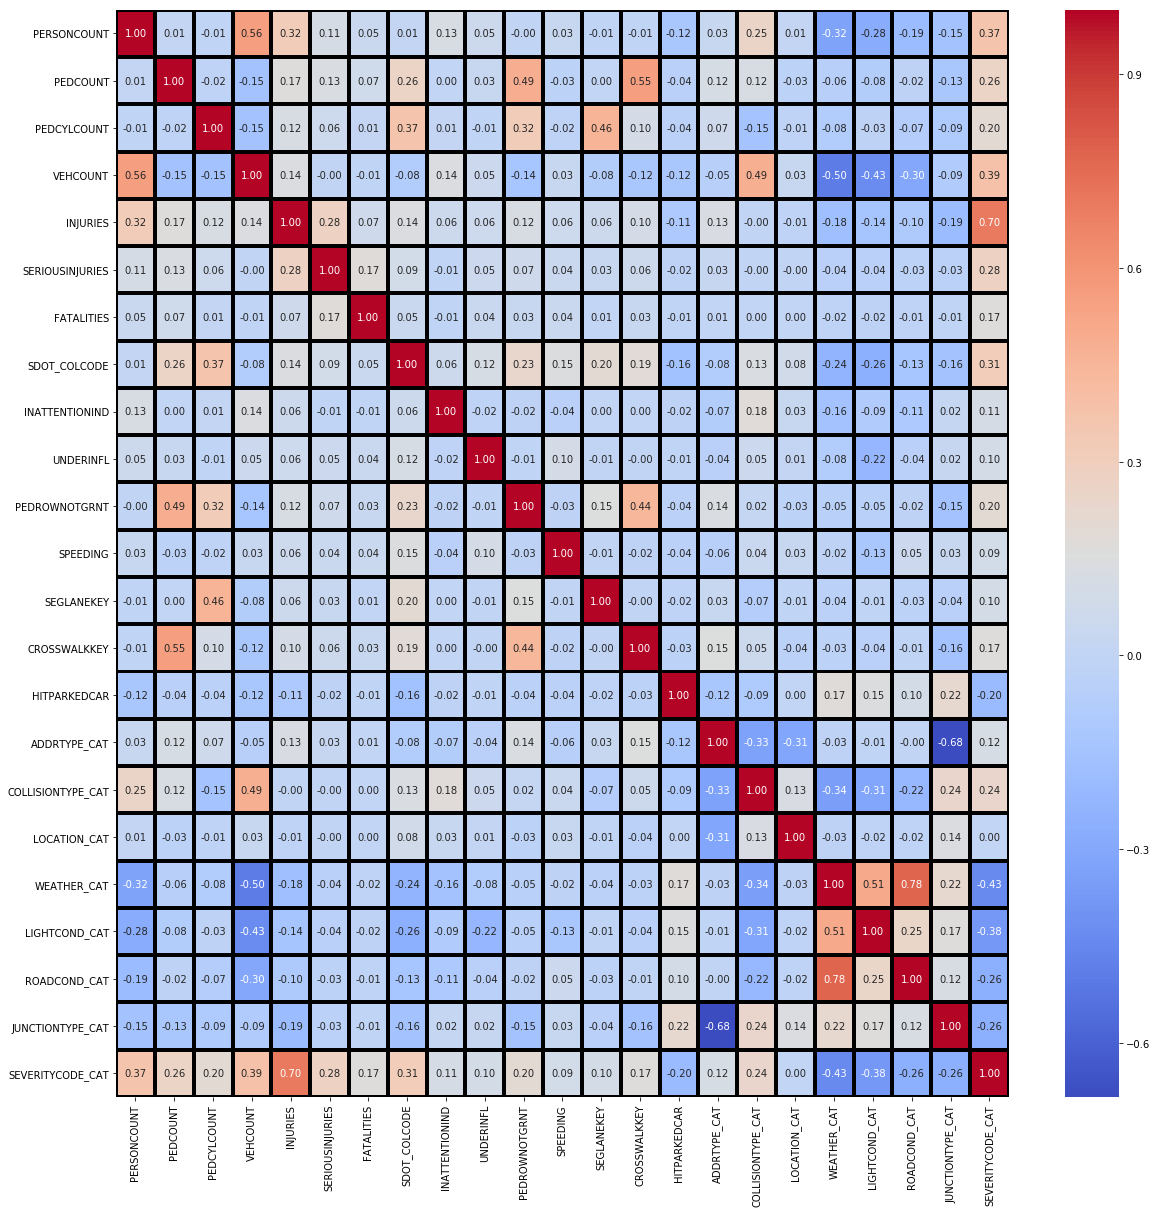

Relevant Features: 
 PERSONCOUNT         0.370575
VEHCOUNT            0.385334
INJURIES            0.700338
WEATHER_CAT         0.434211
LIGHTCOND_CAT       0.380792
SEVERITYCODE_CAT    1.000000
Name: SEVERITYCODE_CAT, dtype: float64


In [10]:
plt.figure(figsize=(20, 20))
cor = df.corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap='coolwarm', linewidths=3, linecolor='black')
plt.show()

#Correlation with output variable
cor_target = abs(cor["SEVERITYCODE_CAT"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.35]
print ("Relevant Features: \n", relevant_features)

The problem statement indicates that the initial feature selection should include the weather and road conditions. The features will be:
* INJURIES
* WEATHER
* VEHCOUNT
* LIGHTCOND
* PERSONCOUNT

The target for the model is _SEVERITYCODE_.

After running several iterations of the models below, it was found that the _FATALITIES_ and _SERIOUSINJURIES_ features needed to be added. The following warning message was being generated:

    `F-score is ill-defined and being set to 0.0 in labels with no predicted samples.`

Taking the difference between the sets _y\_test_ and _yhat_ showed that the _SEVERITYCODE_ values _Serious Injury Collision_ and  _Fatality Collision_ were not being predicted. Adding the _FATALITIES_ and _SERIOUSINJURIES_ features resolved the warning.

In [11]:
print("Rows before cleaning: ", df.shape)
df = df[~df['WEATHER'].isin(['Unknown'])]
df = df[~df['WEATHER'].isin(['Other'])]
df = df[~df['LIGHTCOND'].isin(['Unknown'])]
df = df[~df['LIGHTCOND'].isin(['Other'])]
df = df[~df['SEVERITYDESC'].isin(['Unknown'])]
print ("Rows after cleaning: ", df.shape)

Rows before cleaning:  (221144, 32)
Rows after cleaning:  (174131, 32)


### Convert Categorical Features to Numeric Values

The feature set for the model consists of the following:
* INJURIES
* FATALITIES
* SERIOUSINJURIES
* WEATHER
* VEHCOUNT
* LIGHTCOND
* PERSONCOUNT

One Hot Encoding will be used for _WEATHER_, _LIGHTCOND_.

In [12]:
Feature = df[['PERSONCOUNT','VEHCOUNT', 'INJURIES', 'FATALITIES', 'SERIOUSINJURIES']]

# do One Hot Encoding
Feature = pd.concat([Feature,pd.get_dummies(df['WEATHER'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df['LIGHTCOND'])], axis=1)
Feature.head()

,PERSONCOUNT,VEHCOUNT,INJURIES,FATALITIES,SERIOUSINJURIES,Clear,Overcast,Raining,Dark,Dawn,Daylight,Dusk
OBJECTID,,,,,,,,,,,,
3,2,2,0,0,0,0,1,0,0,0,1,0
5,2,2,0,0,0,1,0,0,0,0,1,0
6,4,2,3,0,0,1,0,0,0,0,1,0
7,2,2,0,0,0,1,0,0,1,0,0,0
8,2,2,0,0,0,1,0,0,0,0,1,0


The desired prediction value will be _SEVERITY_DESC_. The feature dataset will be run through the Standard Scaller to normalize all of the data. The dataset will then be split into a training set for the models and a test set to evaluate how good the models are at prediction.

In [13]:
X = Feature
y = df['SEVERITYDESC'].values

X= preprocessing.StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (139304, 12) (139304,)
Test set: (34827, 12) (34827,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


## Analysis <a name="analysis"></a>
Four models will be developed. The accurracy, Jaccard index, F1 score, and LogLoss will be calculated.

## K Nearest Neighbor (KNN)

In [14]:
Ks = 10
mean_accKNN = np.zeros((Ks-1))
mean_errKNN = np.zeros((Ks-1))
mean_jacKNN = np.zeros((Ks-1))
mean_F1KNN  = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict
    print ("Ks = ", n)
    neigh = KNeighborsClassifier(n_neighbors=n, n_jobs=1, weights='distance').fit(X_train,y_train)
    yhat=neigh.predict(X_test)

    mean_accKNN[n-1] = metrics.accuracy_score(y_test, yhat)
    mean_errKNN[n-1] = (np.mean(yhat != y_test))
    mean_jacKNN[n-1] = jaccard_similarity_score(y_test, yhat)
    mean_F1KNN[n-1]  = f1_score(y_test, yhat, average='weighted')
    print(confusion_matrix(y_test, yhat))
    print(classification_report(y_test, yhat))
    print ("Unsolved values: ", set(y_test) - set(yhat))   
    
print ("KNN Accuracy table: ", mean_accKNN)
print( "The best accuracy is", mean_accKNN.max(), "with k=", mean_accKNN.argmax()+1) 

print ("KNN Error table: ", mean_errKNN)
print( "The best error is", mean_errKNN.min(), "with k=", mean_errKNN.argmin()+1) 

print ("KNN Jaccard index table: ", mean_jacKNN)
print( "The best Jaccard index is", mean_jacKNN.max(), "with k=", mean_jacKNN.argmax()+1) 

print ("KNN F1-score table: ", mean_F1KNN)
print( "The best F1-score is", mean_F1KNN.max(), "with k=", mean_F1KNN.argmax()+1) 

Ks =  1
[[   67     0     0     0]
 [    0 11073     6     0]
 [    0     3 23043     0]
 [    0     1     0   634]]
                                precision    recall  f1-score   support

            Fatality Collision       1.00      1.00      1.00        67
              Injury Collision       1.00      1.00      1.00     11079
Property Damage Only Collision       1.00      1.00      1.00     23046
      Serious Injury Collision       1.00      1.00      1.00       635

                     micro avg       1.00      1.00      1.00     34827
                     macro avg       1.00      1.00      1.00     34827
                  weighted avg       1.00      1.00      1.00     34827

Unsolved values:  set()
Ks =  2
[[   67     0     0     0]
 [    0 11073     6     0]
 [    0     3 23043     0]
 [    0     1     0   634]]
                                precision    recall  f1-score   support

            Fatality Collision       1.00      1.00      1.00        67
              Inju

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
Ks = 15
mean_accDT = np.zeros((Ks-1))
mean_errDT = np.zeros((Ks-1))
mean_jacDT = np.zeros((Ks-1))
mean_F1DT  = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict
    print ("Ks = ", n)
    DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    DT_model.fit(X_train,y_train)
    yhat = DT_model.predict(X_test)

    mean_accDT[n-1] = metrics.accuracy_score(y_test, yhat)
    mean_errDT[n-1] = (np.mean(yhat != y_test))
    mean_jacDT[n-1] = jaccard_similarity_score(y_test, yhat)
    mean_F1DT[n-1]  = f1_score(y_test, yhat, average='weighted')
    print(confusion_matrix(y_test, yhat))
    print(classification_report(y_test, yhat))
    print ("Unsolved values: ", set(y_test) - set(yhat))
    
print ("Decision Tree Accuracy table: ", mean_accDT)
print( "The best accuracy is", mean_accDT.max(), "with k=", mean_accDT.argmax()+1) 

print ("Decision Tree Error table: ", mean_errDT)
print( "The best error is", mean_errDT.min(), "with k=", mean_errDT.argmin()+1) 

print ("Decision Tree Jaccard index table: ", mean_jacDT)
print( "The best Jaccard index is", mean_jacDT.max(), "with k=", mean_jacDT.argmax()+1) 

print ("Decision Tree F1-score table: ", mean_F1DT)
print( "The best F1-score is", mean_F1DT.max(), "with k=", mean_F1DT.argmax()+1) 

Ks =  1


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[    0    28    39     0]
 [    0 11079     0     0]
 [    0     0 23046     0]
 [    0   634     1     0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                precision    recall  f1-score   support

            Fatality Collision       0.00      0.00      0.00        67
              Injury Collision       0.94      1.00      0.97     11079
Property Damage Only Collision       1.00      1.00      1.00     23046
      Serious Injury Collision       0.00      0.00      0.00       635

                     micro avg       0.98      0.98      0.98     34827
                     macro avg       0.49      0.50      0.49     34827
                  weighted avg       0.96      0.98      0.97     34827

Unsolved values:  {'Serious Injury Collision', 'Fatality Collision'}
Ks =  2
[[   39    17     0    11]
 [    0 11079     0     0]
 [    0     0 23046     0]
 [    0     0     1   634]]
                                precision    recall  f1-score   support

            Fatality Collision       1.00      0.58      0.74        67
              Injury Collision       1.00      1.00      1.00     11079
Property Damage On

## Support Vector Machine

In [16]:
from sklearn import svm
SVM_model = svm.SVC(gamma='scale')
SVM_model.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
yhat = SVM_model.predict(X_test)
print ("The SVM model accuracy is: ", metrics.accuracy_score(y_test, yhat))
print ("The SVM model error is: ", np.mean(yhat != y_test))
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_test, yhat))
print("SVM F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
print ("Unsolved values: ", set(y_test) - set(yhat))   

The SVM model accuracy is:  0.9996841530996067
The SVM model error is:  0.000315846900393373
SVM Jaccard index: 1.00
SVM F1-score: 1.00
[[   64     3     0     0]
 [    0 11076     3     0]
 [    0     1 23045     0]
 [    0     4     0   631]]
                                precision    recall  f1-score   support

            Fatality Collision       1.00      0.96      0.98        67
              Injury Collision       1.00      1.00      1.00     11079
Property Damage Only Collision       1.00      1.00      1.00     23046
      Serious Injury Collision       1.00      0.99      1.00       635

                     micro avg       1.00      1.00      1.00     34827
                     macro avg       1.00      0.99      0.99     34827
                  weighted avg       1.00      1.00      1.00     34827

Unsolved values:  set()


## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01, solver='lbfgs', multi_class='auto').fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
yhat = LR_model.predict(X_test)
print ("The LR model accuracy is: ", metrics.accuracy_score(y_test, yhat))
print ("The LR model error is: ", np.mean(yhat != y_test))
yhat_prob = LR_model.predict_proba(X_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, yhat))
print("LR F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, yhat_prob))
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
print ("Unsolved values: ", set(y_test) - set(yhat))   

The LR model accuracy is:  0.9998277198725127
The LR model error is:  0.00017228012748729435
LR Jaccard index: 1.00
LR F1-score: 1.00
LR LogLoss: 0.01
[[   67     0     0     0]
 [    0 11079     0     0]
 [    0     0 23046     0]
 [    0     5     1   629]]
                                precision    recall  f1-score   support

            Fatality Collision       1.00      1.00      1.00        67
              Injury Collision       1.00      1.00      1.00     11079
Property Damage Only Collision       1.00      1.00      1.00     23046
      Serious Injury Collision       1.00      0.99      1.00       635

                     micro avg       1.00      1.00      1.00     34827
                     macro avg       1.00      1.00      1.00     34827
                  weighted avg       1.00      1.00      1.00     34827

Unsolved values:  set()


## Results and Discussion <a name="results"></a>

The following results were observed from the models:

| Model | accuracy | error | Jaccard Index | F1-score | logloss |
|-------|----------|-------|---------------|----------|---------|
| K Nearest Neighbor| 0.9997415798087691 | 0.0002584201912309415 | 0.9997415798087691 | 0.9997415542813086 | NA |
| Decision Tree | 1.0 | 0.0 | 1.0 | 1.0 | NA |
| Support Vector Machine | 0.9996841530996067 | 0.000315846900393373 | 1.0 | 1.0 | NA |
| Logistic Regression | 0.9998277198725127 | 0.00017228012748729435 | 1.0 | 1.0 | 0.01 |


All of the models give excellent results usimg the test data set. The Decision Tree would be the model of choice if one had to be chosen.

There were some surprises in the analysis of the data. _LOCATION_ was not a major factor in where collisions took place. Another surprise is that _ROADCOND_ was also not an influence in the severity of a collission.

## Conclusion <a name="conclusion"></a>

It is very possible to deliver a service that meets the problem statement. The data that would be immediately available from a collission could be used to warn motorists of potentially unsafe driving conditions.